In [7]:
import firedrake
import matplotlib.pyplot as plt
import icepack.plot
from firedrake import inner, as_vector
import icepack
from firedrake import ds
import numpy as np
import math


In [8]:
# Read in the mesh used in the Elmer/Ice simulations

mesh = firedrake.Mesh("Meshes/Flux150Sigma3000.msh")


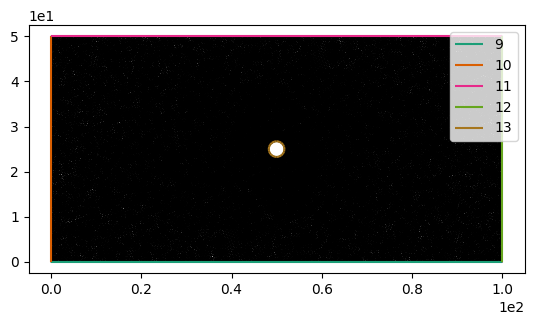

In [9]:
#Plot the mesh

fig, axes = icepack.plot.subplots()
icepack.plot.triplot(mesh, axes=axes)
axes.legend();


In [10]:

x, y = firedrake.SpatialCoordinate(mesh)

In [11]:
# Define the function spaces

Q = firedrake.FunctionSpace(mesh, "CG", 2)
V = firedrake.VectorFunctionSpace(mesh, "CG", 2)

In [12]:
# Define the inflow boundary velocity and thickness
u_out = 2.0 #initial guess at what the outflow velocity should be
u_in = 2.0 #velocity at inflow boundary (kept fixed through simulation)
h_in = 1.0 #inflow thickness (also kept constant)
Ly = 1.5e5/3000

us = []

#Define regular shelf flow, but with circular repression around the centre of the ice rise
center = [1.5e5/3000,0.75e5/3000]
distance = firedrake.interpolate(firedrake.sqrt((x-center[0])**2 + (y-center[1])**2),Q)
#where distance==min_dist is where the boundary of the domain is
min_dist = distance.dat.data.min()

u_0_x = 0.0
#u_0_y = - u_in / (1.0 + firedrake.exp(-0.0005*(y-25000.0))) + u_in
#Flow should only be affected near the ice rise, so we repress the flow near the ice rise, otherwise just multiply by 1 for no change.
u_0_y = (u_in + (u_out - u_in) * ((y/Ly)**2)) *firedrake.min_value(1.0, (distance-min_dist)/(3000*1e4))


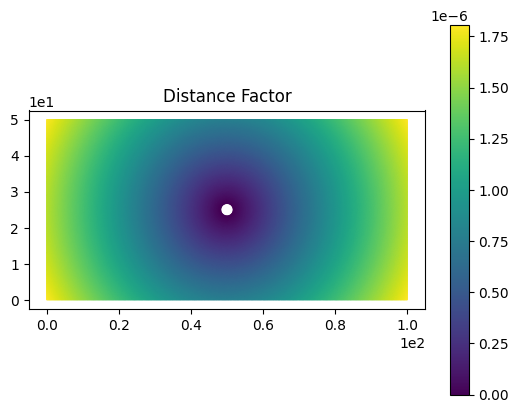

In [13]:
fac = firedrake.interpolate(firedrake.min_value(1.0, (distance-min_dist)/(3000*1e4)),Q)
fig, axes = icepack.plot.subplots()
axes.set_title("Distance Factor")
colors = icepack.plot.tripcolor(fac, axes=axes)
fig.colorbar(colors);

In [14]:

h_expr = firedrake.Constant(h_in)
h0 = firedrake.interpolate(h_expr, Q)
u0 = firedrake.interpolate(firedrake.as_vector((u_0_x,u_0_y)), V)
#u0 = firedrake.interpolate(u_expr, V)


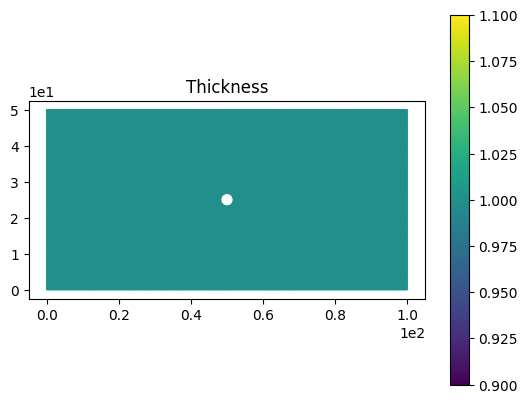

In [15]:
# Plot the initial ice thickness

fig, axes = icepack.plot.subplots()
axes.set_title("Thickness")
colors = icepack.plot.tripcolor(h0, axes=axes)
fig.colorbar(colors);


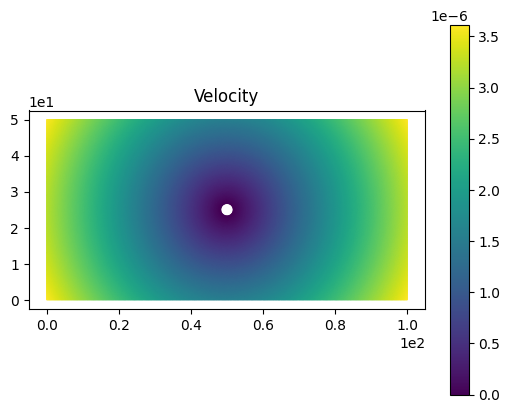

In [16]:
# Plot the initial ice thickness

fig, axes = icepack.plot.subplots()
axes.set_title("Velocity")
colors = icepack.plot.tripcolor(u0, axes=axes)
fig.colorbar(colors);


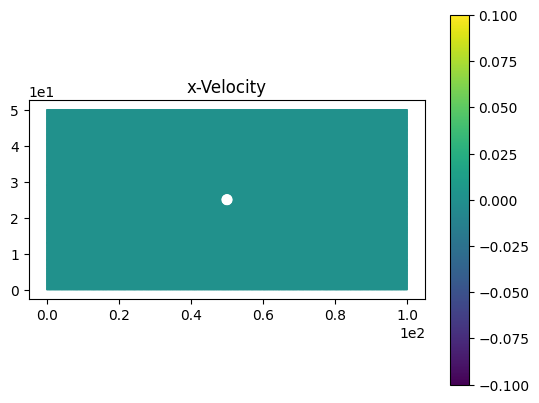

In [17]:
#Make sure the x-velocity respects the side wall boundary condition

ux = firedrake.interpolate(u0[0],Q)
uy = firedrake.interpolate(u0[1],Q)
fig, axes = icepack.plot.subplots()
axes.set_title("x-Velocity")
colors = icepack.plot.tripcolor(ux, axes=axes)
fig.colorbar(colors);

In [18]:
# Define which model we will be using

model = icepack.models.IceShelf()
opts = {
    "dirichlet_ids": [9,13],
    "side_wall_ids": [10,12],
    # Numerical solver options - potentially can play around with them to get better convergence
    # "diagnostic_solver_type": "petsc",
    # "diagnostic_solver_parameters": {
    #     "snes_type": "newtontr",
    #     "ksp_type": "gmres",
    #     "pc_type": "lu",
    #     "pc_factor_mat_solver_type": "mumps",
    # },
}
solver = icepack.solvers.FlowSolver(model, **opts)


In [19]:
# Set A(T)

T = firedrake.Constant(255.15)
A = icepack.rate_factor(T)


In [20]:
# Set up the model initially

h = h0.copy(deepcopy=True)
u = solver.diagnostic_solve(
    velocity=u0,
    thickness=h,
    fluidity=A,
)


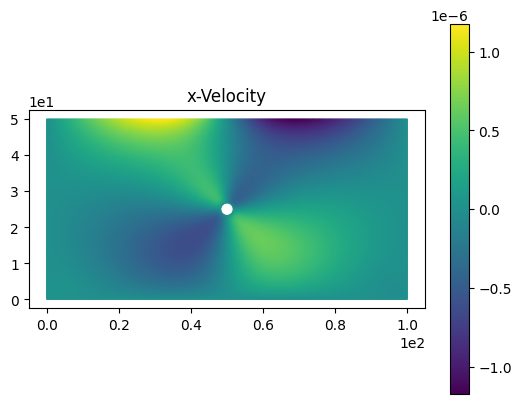

In [21]:
#Side wall bonudary conditions should still be repsected after the diagnostic solve!
ux = firedrake.interpolate(u[0],Q)
uy = firedrake.interpolate(u[1],Q)
fig, axes = icepack.plot.subplots()
axes.set_title("x-Velocity")
colors = icepack.plot.tripcolor(ux, axes=axes)
fig.colorbar(colors);

In [22]:
print(u.at([1.5e5,0.711e5]))

PointNotInDomainError: domain <Mesh #5> does not contain point [150000.  71100.]

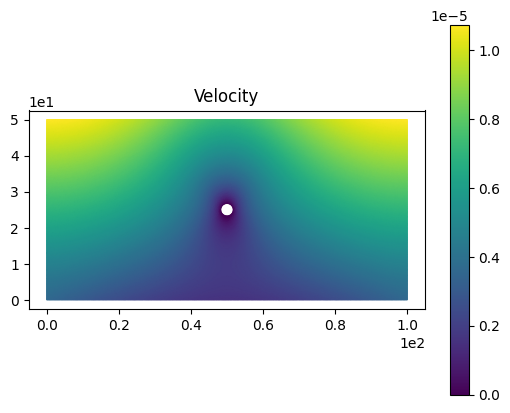

In [23]:
fig, axes = icepack.plot.subplots()
axes.set_title("Velocity")
colors = icepack.plot.tripcolor(uy, axes=axes)
fig.colorbar(colors);

In [24]:
import tqdm

final_time = 10
num_timesteps = 10
dt = final_time / num_timesteps
a = firedrake.Constant(0.0)

for step in tqdm.trange(num_timesteps):
    h = solver.prognostic_solve(
        dt,
        thickness=h, 
        velocity=u,
        accumulation=a,
        thickness_inflow=h0,
    )
    h = firedrake.interpolate(firedrake.max_value(h,0.001),Q)
    
    u = solver.diagnostic_solve(
        velocity=u,
        thickness=h,
        fluidity=A,
    )

100%|███████████████████████████████████████████| 10/10 [00:42<00:00,  4.26s/it]


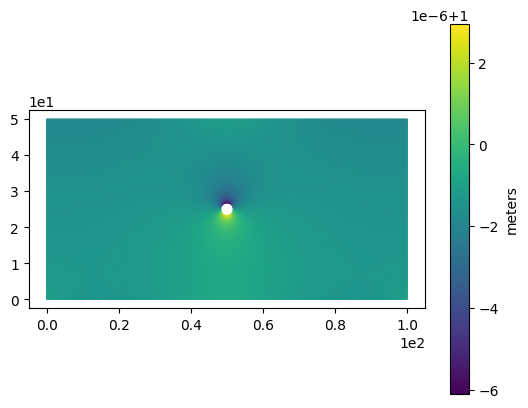

In [25]:
fig, axes = icepack.plot.subplots()
colors = icepack.plot.tripcolor(h, axes=axes)
fig.colorbar(colors, label="meters");

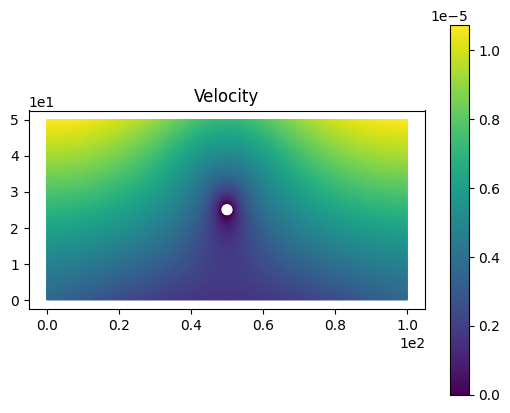

In [26]:

fig, axes = icepack.plot.subplots()
axes.set_title("Velocity")
colors = icepack.plot.tripcolor(u, axes=axes)
fig.colorbar(colors);


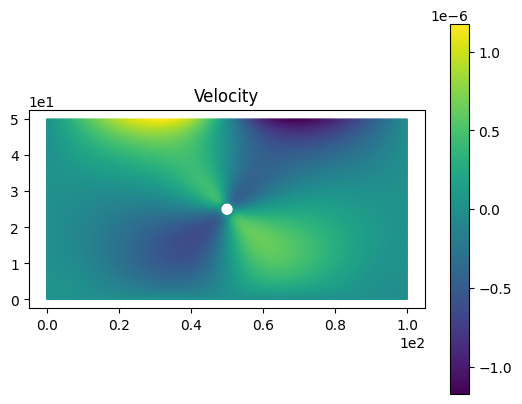

In [27]:
ux = firedrake.interpolate(u[0],Q)
uy = firedrake.interpolate(u[1],Q)
fig, axes = icepack.plot.subplots()
axes.set_title("Velocity")
colors = icepack.plot.tripcolor(ux, axes=axes)
fig.colorbar(colors);

/var/folders/7m/lgqxn0610bs8sxwnf4k6z_hw0000gn/T/ipykernel_16935/1095716043.py:5: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(streamlines, label="meters/year");


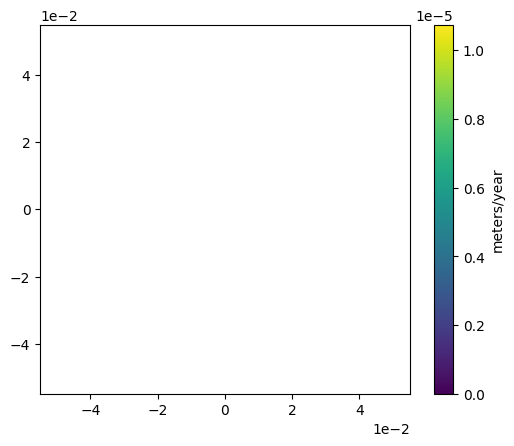

In [28]:
fig, axes = icepack.plot.subplots()
streamlines = icepack.plot.streamplot(
    u, precision=1e3, density=2e3, axes=axes
)
fig.colorbar(streamlines, label="meters/year");

In [29]:
from icepack.constants import (
    ice_density as ρ_I,
    water_density as ρ_W,
    gravity as g,
)
from firedrake import grad

τ_d = firedrake.interpolate(
    -1e3 * ρ_I * g * (1 - ρ_I / ρ_W) * grad(h**2), V
)

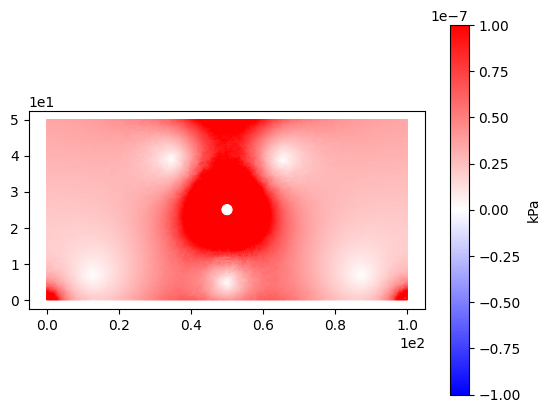

In [36]:
fig, axes = icepack.plot.subplots()
colors = icepack.plot.tripcolor(τ_d, vmin=-0.0000001, vmax=0.0000001, axes=axes, cmap='bwr')
fig.colorbar(colors, label="kPa");